# Preprocessing

In [1]:
import numpy as np
import dask.array as da
import h5py

%matplotlib inline
%run mpl_setup.py
import matplotlib.pyplot as plt

Input files and datasets:

In [2]:
# Tau-level datasets
sigf_jet = h5py.File("C:/Users/chris/Desktop/new-samples-v2/sig1P_jet_shuffle.h5", "r")
bkgf_jet = h5py.File("C:/Users/chris/Desktop/new-samples-v2/bkg1P_jet_shuffle.h5", "r")
sig_jet_ds = sigf_jet["jet"]
bkg_jet_ds = bkgf_jet["jet"]

sig_jet = da.from_array(sig_jet_ds, chunks=sig_jet_ds.chunks)
bkg_jet = da.from_array(bkg_jet_ds, chunks=bkg_jet_ds.chunks)

# Track-level datasets
sigf_track = h5py.File("C:/Users/chris/Desktop/new-samples-v2/sig1P_track_shuffle.h5", "r")
bkgf_track = h5py.File("C:/Users/chris/Desktop/new-samples-v2/bkg1P_track_shuffle.h5", "r")
sig_track_ds = sigf_track["track"]
bkg_track_ds = bkgf_track["track"]

sig_track = da.from_array(sig_track_ds, chunks=sig_track_ds.chunks)
bkg_track = da.from_array(bkg_track_ds, chunks=bkg_track_ds.chunks)

Slimmed list of variables:

In [3]:
invars = ["TauTracks.qOverP", "TauTracks.z0sinThetaTJVA", "TauTracks.d0",
          "TauTracks.dRJetSeedAxis", "TauTracks.rConvII", "TauTracks.nInnermostPixelHits",
          "TauTracks.nPixelHits", "TauTracks.nSiHits", "TauTracks.eProbabilityHT"]

Sample fractions for training/validation

In [4]:
total_frac = 0.2
idx = int(total_frac * min(len(sig_track), len(bkg_track)))
val_frac = 0.25
val_split = int((1.0 - val_frac) * idx)
n_tracks = 10

print("[0:{}] for RNN-training".format(val_split))
print("[{}:{}] for validation".format(val_split, idx))

[0:988859] for RNN-training
[988859:1318479] for validation


## Loading, slimming, splitting, merging

In [5]:
# Fraction of entire dataset
sig_jet = sig_jet[:idx]
bkg_jet = bkg_jet[:idx]

sig_track = sig_track[:idx, :n_tracks]
bkg_track = bkg_track[:idx, :n_tracks]

Add nan padding in sample preparation step to avoid this part:

In [6]:
# Convert structured array to ndarray
sig_track_view = sig_track.view(np.float32).reshape(sig_track.shape + (-1,))
bkg_track_view = bkg_track.view(np.float32).reshape(bkg_track.shape + (-1,))

In [8]:
# Set tracks with all zeros to nan
sig_all_zero = da.all(sig_track_view == 0, axis=2, keepdims=True)
bkg_all_zero = da.all(bkg_track_view == 0, axis=2, keepdims=True)

# Broadcast the reduced axis back to full size
sig_mask = da.broadcast_to(sig_all_zero, sig_track_view.shape)
bkg_mask = da.broadcast_to(bkg_all_zero, bkg_track_view.shape)

# Set nan
sig_track_view[sig_mask] = np.nan
bkg_track_view[bkg_mask] = np.nan

In [17]:
sig_track = {fieldname: sig_track_view[..., i] for i, fieldname in enumerate(sig_track.dtype.names)}
bkg_track = {fieldname: bkg_track_view[..., i] for i, fieldname in enumerate(bkg_track.dtype.names)}

In [ ]:
# Slim variables
#sig_split = sig_split[invars]
#bkg_split = bkg_split[invars]

### Calculate extra variables

In [18]:
sig_charge = da.sign(sig_track["TauTracks.qOverP"])
bkg_charge = da.sign(bkg_track["TauTracks.qOverP"])

In [19]:
sig_pt_track = sig_track["TauTracks.pt"]
bkg_pt_track = bkg_track["TauTracks.pt"]

In [20]:
sig_pt_jet = sig_jet["TauJets.ptJetSeed"][:, np.newaxis]
bkg_pt_jet = sig_jet["TauJets.ptJetSeed"][:, np.newaxis]

In [21]:
sig_pt_frac = sig_pt_track / sig_pt_jet
bkg_pt_frac = bkg_pt_track / bkg_pt_jet

In [22]:
s = sig_pt_frac[:, 0].compute()
b = bkg_pt_frac[:, 0].compute()

In [23]:
np.count_nonzero(b > 2.0) / float(len(s))

0.10369372587655928

In [24]:
np.max([np.percentile(b, 34), np.percentile(s, 34)])

0.41606630682945256

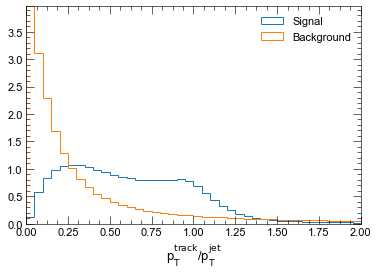

In [25]:
plt.hist(s, bins=40, range=(0, 2), histtype="step", normed=True, label="Signal")
plt.hist(b, bins=40, range=(0, 2), histtype="step", normed=True, label="Background")
plt.legend()
plt.xlabel("$p_\mathrm{T}^\mathrm{track} / p_\mathrm{T}^\mathrm{jet}$")

### Continue slimming

In [19]:
# Train split
sig_train = sig_split[:val_split]
bkg_train = bkg_split[:val_split]

# Validation split
sig_val = sig_split[val_split:idx]
bkg_val = bkg_split[val_split:idx]

# Concatenate sig & bkg
train = da.vstack((sig_train, bkg_train))
validation = da.vstack((sig_val, bkg_val))

# Sample labels
train_label = da.concatenate(
    (da.ones(val_split, dtype=np.float32, chunks=1000000),
     da.zeros(val_split, dtype=np.float32, chunks=1000000))
)
validation_label = da.concatenate(
    (da.ones(idx - val_split, dtype=np.float32, chunks=1000000), 
     da.zeros(idx - val_split, dtype=np.float32, chunks=1000000)))

## Subtract mean, divide by stddev

In [20]:
offset = da.nanmean(train, axis=0)
scale = da.nanstd(train, axis=0)

train -= offset
train /= scale

validation -= offset
validation /= scale

## $p_\mathrm{T}$-reweighting

In [21]:
sig_pt = sig_tau_ds[:idx, "TauJets.pt"]
bkg_pt = bkg_tau_ds[:idx, "TauJets.pt"]

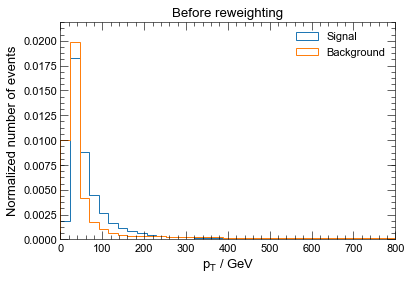

In [22]:
plt.hist(sig_pt / 1000.0, bins=35, range=(0, 800), histtype="step", normed=True, label="Signal")
plt.hist(bkg_pt / 1000.0, bins=35, range=(0, 800), histtype="step", normed=True, label="Background")
plt.legend()
lo, hi = plt.ylim()
plt.ylim((lo, 1.1 * hi))
plt.xlabel("$p_\mathrm{T}$ / GeV")
plt.ylabel("Normalized number of events")
plt.title("Before reweighting")

In [23]:
bin_edges = np.percentile(bkg_pt, np.linspace(0.0, 100.0, 30))
bin_edges[0] = 20000.0 # 20 GeV lower limit
bin_edges[-1] = 4000000.0 # 4000 GeV upper limit
midpoints = (bin_edges[1:] + bin_edges[:-1]) / 2.0

In [24]:
sig_hist, _ = np.histogram(sig_pt, bins=bin_edges, density=True)
bkg_hist, _ = np.histogram(bkg_pt, bins=bin_edges, density=True)
nsig_hist, _ = np.histogram(sig_pt, bins=bin_edges)
nbkg_hist, _ = np.histogram(bkg_pt, bins=bin_edges)

In [25]:
coeff = sig_hist / bkg_hist

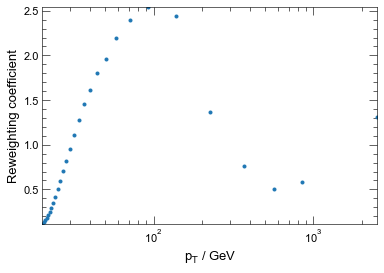

In [26]:
plt.plot(midpoints / 1000.0, coeff, ".")
plt.xlabel("$p_\mathrm{T}$ / GeV")
plt.ylabel("Reweighting coefficient")
plt.xscale("log")

In [27]:
sig_weight = np.ones_like(sig_pt)
bkg_weight = coeff[np.digitize(bkg_pt, bin_edges) - 1].astype(np.float32)

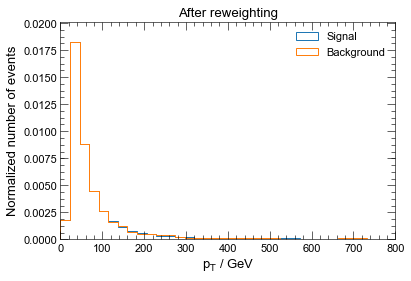

In [28]:
plt.hist(sig_pt / 1000.0, weights=sig_weight, bins=35, range=(0, 800), histtype="step", normed=True, label="Signal")
plt.hist(bkg_pt / 1000.0, weights=bkg_weight, bins=35, range=(0, 800), histtype="step", normed=True, label="Background")
plt.legend()
lo, hi = plt.ylim()
plt.ylim((lo, 1.1 * hi))
plt.xlabel("$p_\mathrm{T}$ / GeV")
plt.ylabel("Normalized number of events")
plt.title("After reweighting")

In [29]:
train_weight = np.concatenate((sig_weight[:val_split], bkg_weight[:val_split]))
validation_weight = np.concatenate((sig_weight[val_split:], bkg_weight[val_split:]))

## Save array and auxiliary info

In [30]:
outf = "split1P_w_weights.h5"

In [31]:
h5opt = dict(compression="gzip", compression_opts=9, fletcher32=True)

In [32]:
da.to_hdf5(outf, {"/train": train, "/train_label": train_label,
                  "/validation": validation, "/validation_label": validation_label,
                  "/offset": offset, "/scale": scale},
           **h5opt)

C:\Users\chris\Miniconda3\envs\ML\lib\site-packages\dask\array\core.py:2544: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.13 because this will return a view instead of a copy -- see release notes for details.
  return function(*args2, **kwargs)


In [33]:
with h5py.File(outf, "a") as f:
    f.create_dataset("/variables", data=np.array(invars, dtype="S"), **h5opt)
    f.create_dataset("/splits", data=np.array([val_split, idx], dtype=np.int32), **h5opt)
    f.create_dataset("/train_weight", data=train_weight, **h5opt)
    f.create_dataset("/validation_weight", data=validation_weight, **h5opt)

In [64]:
sigf_jet.close()
bkgf_jet.close()
sigf_track.close()
bkgf_track.close()